# Exercice 3 - Support Vector Classifier

# Support Vector Machines

In [1]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

# notebook only
%matplotlib inline
    
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import seaborn as sns

# pour comparaison
from sklearn.svm import SVC

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

In [2]:
def plotHyperSurface(ax, xRange, model, intercept, label, color='grey', linestyle='-', alpha=1.):
    #xx = np.linspace(-1, 1, 100)
    if model.type=='linear':
        xRange = np.array(xRange)
        yy = -(model.w[0] / model.w[1]) * xRange  - intercept/model.w[1]
        ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    else:
        xRange = np.linspace(xRange[0], xRange[1], 100)
        X0, X1 = np.meshgrid(xRange, xRange)
        xy = np.vstack([X0.ravel(), X1.ravel()]).T
        Y30 = model.separating_function(xy).reshape(X0.shape) + intercept
        ax.contour(X0, X1, Y30, colors=color, levels=[0.], alpha=alpha, linestyles=[linestyle]);
       
        
def plotClassification(X, y, model=None, label='',  separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    colors = ['blue','red']
    labels = [1,-1]
    cmap = pltcolors.ListedColormap(colors)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(11, 7))
    for k, label in enumerate(labels):
        im = ax.scatter(X[y==label,0], X[y==label,1],  alpha=0.5,label='class '+str(label))

    if model is not None:
        # Plot the seprating function
        plotHyperSurface(ax, bound[0], model, model.b, separatorLabel)
        if model.support is not None:
            ax.scatter(model.support[:,0], model.support[:,1], label='Support', s=80, facecolors='none', edgecolors='r', color='r')
            print("Number of support vectors = %d" % (len(model.support)))
        
        # Plot the margins
        signedDist = model.separating_function(model.support)
        intercept_neg = -np.min(signedDist) ### compute the intercept for the negative margin
        intercept_pos = -np.max(signedDist) ### compute the intercept for the positive margin
        xx = np.array(bound[0])
        plotHyperSurface(ax, xx, model, intercept_neg , 'Margin -', linestyle='-.', alpha=0.8)
        plotHyperSurface(ax, xx, model, intercept_pos , 'Margin +', linestyle='--', alpha=0.8)

        # Plot points on the wrong side of the margin
        totalsignedDist = model.separating_function(X)
        supp_min = X[(totalsignedDist > np.min(signedDist)) * (y == -1)]
        supp_max = X[(totalsignedDist < np.max(signedDist)) * (y == 1)]
        wrong_side_points = np.concatenate([supp_min, supp_max], axis=0) # find wrong points
        # wrong_side_points = X[y*(model.separating_function(X)+model.b)<1] # find wrong points
        ax.scatter(wrong_side_points[:,0], wrong_side_points[:,1], label='Beyond the margin', s=80, facecolors='none', 
               edgecolors='grey', color='grey')  
        
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])

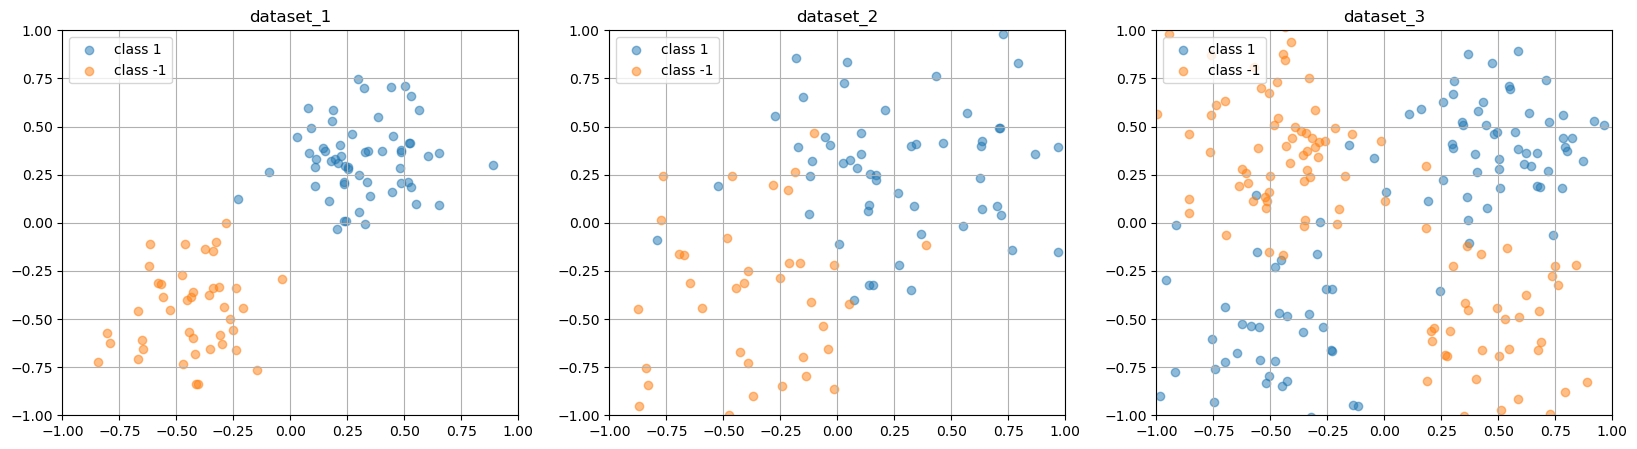

In [3]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
fig, ax = plt.subplots(1,3, figsize=(20, 5))

for i, (name, dataset) in enumerate(datasets.items()):    
    plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax[i])
    ax[i].set_title(name)

## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF and linear below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_j\Vert^2/(2\sigma^2))$ for the RBF kernel and $k(x_i,y_j)= x_i^{\top}y_j$ for the linear kernel. (The fastest solution does not use any for loop!)

In [4]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        squared_distances = np.array([ [ np.sum((X[i,:]-Y[j,:])**2) for j in range(Y.shape[0]) ] for i in range(X.shape[0])])
        return np.exp( -1/(2*self.sigma**2) * squared_distances )

In [5]:
class Linear:
    def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return  X @ Y.T

## Question 1

Representer theorem :

$f(x) = \sum_{i=1}^n \alpha_i \textbf{K}(x_i,x)$

$\underline{Lagrangien}$ :

$\mathcal{L}(\alpha,\xi,b, \mu,\nu) = \frac{1}{2}\alpha^T \textbf{K} \alpha + C \sum_{i=1}^{n}\xi_i - \sum_{i=1}^{n} \mu_i \left( y_i ( [\textbf{K}\alpha]_i + b) + \xi_i - 1 \right) - \sum_{i=1}^{n} \nu_i \xi_i$

$\underline{Gradients}$ :

$\nabla_\alpha \mathcal{L} = \textbf{K} \left( \alpha - \text{diag}(y)\mu \right)$

$\nabla_\xi \mathcal{L} = C \textbf{1} - (\nu + \mu)$

$\nabla_b \mathcal{L} = \mu^T y$

$\underline{Optimal \, points}$ :

$\alpha^* = \text{diag}(y) \mu$

$\mu + \nu = C\textbf{1}$

$\mu^T y = 0$

NB on note : $\alpha_i = y_i \mu_i$, $\mu_i = \alpha_i y_i$, $\nu_i + \mu_i = C$, $\forall i$

$\underline{Dual \, function}$ :

$g(\nu,\mu) = \underset{\alpha, \xi, b}{\text{inf}}\,\,\mathcal{L} = -\frac{1}{2} \text{diag}(y) \mu^T \textbf{K} \mu \text{diag}(y) + \mu^T \textbf{1}$

st $\mu + \nu = C$ et $\mu^T y = 0$

$\underline{Complementary \, slackness}$ :

$\alpha_i \left( y_i (f(x_i) + b) + \xi_i - 1 \right) = 0, \,\, \forall i$

$\left( C y_i - \alpha_i\right) \xi_i = 0, \,\, \forall i$

$\underline{Dual \, problem}$ :

$ \underset{\alpha}{\text{min}} \,\, \frac{1}{2}\alpha^T \textbf{K} \alpha - \alpha^T y $

st : $0 \leq \alpha_i y_i \leq C, \,\, \forall i$ et $ \alpha^T \textbf{1} = 0$

(NB : on utilise le fait que $\sum_i \mu_i y_i = \sum_i \alpha_i y_i^2 = \sum_i \alpha_i$ puisque $y_i = \pm 1$...)

$\underline{Support \, vector \, points}$ :

$\alpha_i = 0 \implies \xi=0, \,\, y_i (f(x_i)+b) > 1$  point bien classé

$\alpha_i y_i = C \implies \xi_i >0, \,\,  y_i (f(x_i)+b) < 1$ point avec marge inférieure à 1

$0 < \alpha_i y_i < C \implies y_i (f(x_i)+b) = 1$ support vector

$\underline{Parameter \, b}$ :

Sur l'ensemble $\mathcal{S}$ des support vectors, on résoud $y_i (f(x_i)+b) = 1$, cad $f(x_i)+b = y_i = \textbf{K}\alpha \vert_i + b$ puis on moyenne, d'où $b = \frac{1}{\vert \mathcal{S} \vert} \sum_{\mathcal{S}} \left( y_i - \textbf{K}\alpha \vert_i \right) $


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [6]:
class KernelSVC:
    
    def __init__(self, C, kernel, type='non-linear', epsilon = 1e-3):
        self.type = type
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None # support vectors
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        self.X = X
        self.y = y
        # compute gram matrix, we might need it :-)
        self.gram = self.kernel(X,X)
        # vector of ones, size N
        self.ones = np.ones(N)
        # matrix NxN of y_i on diagonal
        self.Dy = np.diag(y)

        # Lagrange dual problem
        def loss(alpha):
            objective_function = 1/2 * alpha @ self.gram @ alpha - alpha @ self.y
            return  objective_function

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            gradient = self.gram @ alpha - self.y
            return gradient

        # equality constraint
        fun_eq = lambda alpha: alpha @ self.ones      
        jac_eq = lambda alpha: self.ones
        # inequality constraint avec la classe LinearConstraint de scipy
        inequality_constraint = LinearConstraint(self.Dy, np.zeros(N), self.C * self.ones)
        
        constraints = ( [{'type': 'eq', 'fun': fun_eq, 'jac': jac_eq},
                        inequality_constraint]
                        )

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints)
        self.alpha = optRes.x

        ## Assign the required attributes
        # list of indices of support vectors in dataset, None if not a support vector
        self.indices_support = np.array([ i if (self.epsilon < self.alpha[i]*self.y[i]) and (self.alpha[i]*self.y[i] <= self.C) else None for i in range(N) ])
        self.indices_support = self.indices_support[self.indices_support != None].astype(int)
        # support vectors (data points on margin)
        self.support = self.X[self.indices_support]
        # alphas on support vectors
        self.alpha_support = self.alpha[self.indices_support]
        # compute b by averaging over support vectors
        b = self.y - self.gram @ self.alpha
        b_sv = b[self.indices_support]
        self.b = np.mean(b_sv)
        # '''------------------------RKHS norm of the function f ------------------------------'''
        self.norm_f = 1/2 * self.alpha @ self.gram @ self.alpha
        
        return self


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return self.kernel(x, self.support) @ self.alpha_support + self.b
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

# 2 b- Implementing the visualization function
Implement the function plotClassification that takes new data as input and the model, then displays separating function and margins along with misclassified points.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import seaborn as sns

def plotHyperSurface(ax, xRange, model, intercept, label, color='grey', linestyle='-', alpha=1.):
    #xx = np.linspace(-1, 1, 100)
    if model.type=='linear':
        xRange = np.array(xRange)
        yy = -(model.w[0] / model.w[1]) * xRange  - intercept/model.w[1]
        ax.plot(xRange, yy, color=color, label=label, linestyle=linestyle)
    else:
        xRange = np.linspace(xRange[0], xRange[1], 100)
        X0, X1 = np.meshgrid(xRange, xRange)
        xy = np.vstack([X0.ravel(), X1.ravel()]).T
        Y30 = model.separating_function(xy).reshape(X0.shape) + intercept
        ax.contour(X0, X1, Y30, colors=color, levels=[0.], alpha=alpha, linestyles=[linestyle]);
       
        
def plotClassification(X, y, model=None, label='',  separatorLabel='Separator', 
            ax=None, bound=[[-1., 1.], [-1., 1.]]):
    """ Plot the SVM separation, and margin """
    colors = ['blue','red']
    labels = [1,-1]
    cmap = pltcolors.ListedColormap(colors)
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(11, 7))
    for k, label in enumerate(labels):
        im = ax.scatter(X[y==label,0], X[y==label,1],  alpha=0.5,label='class '+str(label))

    if model is not None:
        # Plot the seprating function
        plotHyperSurface(ax, bound[0], model, model.b, separatorLabel)
        if model.support is not None:
            ax.scatter(model.support[:,0], model.support[:,1], label='Support', s=80, facecolors='none', edgecolors='r', color='r')
            print("Number of support vectors = %d" % (len(model.support)))
        
        # Plot the margins
        signedDist = model.separating_function(model.support)
        intercept_neg = -np.min(signedDist) ### compute the intercept for the negative margin
        intercept_pos = -np.max(signedDist) ### compute the intercept for the positive margin
        xx = np.array(bound[0])
        plotHyperSurface(ax, xx, model, intercept_neg , 'Margin -', linestyle='-.', alpha=0.8)
        plotHyperSurface(ax, xx, model, intercept_pos , 'Margin +', linestyle='--', alpha=0.8)

        # Plot points on the wrong side of the margin
        totalsignedDist = model.separating_function(X)
        supp_min = X[(totalsignedDist > np.min(signedDist)) * (y == -1)]
        supp_max = X[(totalsignedDist < np.max(signedDist)) * (y == 1)]
        wrong_side_points = np.concatenate([supp_min, supp_max], axis=0) # find wrong points
        # wrong_side_points = X[y*(model.separating_function(X)+model.b)<1] # find wrong points
        ax.scatter(wrong_side_points[:,0], wrong_side_points[:,1], label='Beyond the margin', s=80, facecolors='none', 
               edgecolors='grey', color='grey')  
        
    ax.legend(loc='upper left')
    ax.grid()
    ax.set_xlim(bound[0])
    ax.set_ylim(bound[1])

### 3- Fitting the classifier

Run the code block below to fit the classifier and report its output.

#### NB : j'ai ajouté une comparaison avec l'implémentation scikit.

### Dataset 1
#### Linear classifier

Number of support vectors = 3


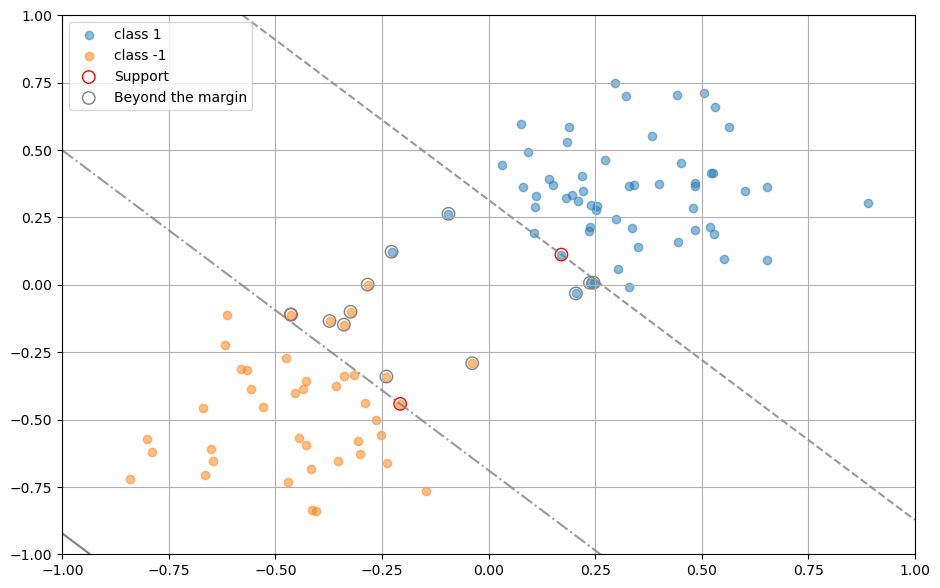

In [8]:
C=1.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Comparaison avec l'algorithme scikit

In [9]:
def print_comparaison():
    
    MAX_SV = 10
    
    print(f"\n")
    print(f"Résultats algorithme maison :-)")
    print(f"Number of support vectors = {len(model.support)}")
    print(f"Support vectors (jusqu'à {MAX_SV}) = {model.support[:MAX_SV]}")
    print(f"Alphas (jusqu'à {MAX_SV}) = {model.alpha[model.indices_support][:MAX_SV]}")
    print(f"b = {model.b}")

    print(f"\n")
    print(f"Résultats algo scikit :")
    print(f"Number of support vectors = {len(clf.support_vectors_)}")
    print(f"Support vectors (jusqu'à {MAX_SV})= {clf.support_vectors_[:MAX_SV]}")
    print(f"Dual coefficients (jusqu'à {MAX_SV})= {clf.dual_coef_[:,:MAX_SV]}")
    print(f"b = {clf.intercept_}")

    #-------------- ANALYSE -----------------------------------------------------
    print(f"\n")
    print(f"Valeur des alpha_i * y_i du modèle maison (à comparer à C={C}), aux indices de vecteurs support indiqués par scikit :")
    print(f"alpha_i * y_i (jusqu'à {MAX_SV}) = {model.alpha[clf.support_][:MAX_SV] * model.y[clf.support_][:MAX_SV]}")

In [10]:
clf = SVC(C=C, kernel='linear')
clf.fit(train_dataset['x'], train_dataset['y'])

print_comparaison()



Résultats algorithme maison :-)
Number of support vectors = 3
Support vectors (jusqu'à 10) = [[-0.4638     -0.11043985]
 [-0.20749121 -0.44200841]
 [ 0.17074108  0.11208645]]
Alphas (jusqu'à 10) = [-0.35864804 -0.47483547  0.83348351]
b = 0.36179455095184215


Résultats algo scikit :
Number of support vectors = 15
Support vectors (jusqu'à 10)= [[-0.4638     -0.11043985]
 [-0.20749121 -0.44200841]
 [-0.23974348 -0.34053975]
 [-0.28374729  0.00067824]
 [-0.37324636 -0.13451019]
 [-0.32392349 -0.10024398]
 [-0.33944758 -0.14801147]
 [-0.0384218  -0.29098337]
 [ 0.2464275   0.00756614]
 [ 0.10667482  0.19157822]]
Dual coefficients (jusqu'à 10)= [[-0.36335253 -0.46890023 -1.         -1.         -1.         -1.
  -1.         -1.          1.          1.        ]]
b = [0.36158901]


Valeur des alpha_i * y_i du modèle maison (à comparer à C=1.0), aux indices de vecteurs support indiqués par scikit :
alpha_i * y_i (jusqu'à 10) = [0.35864804 0.47483547 1.         1.         1.         1.
 1.   

#### Gaussian classifier

Number of support vectors = 22


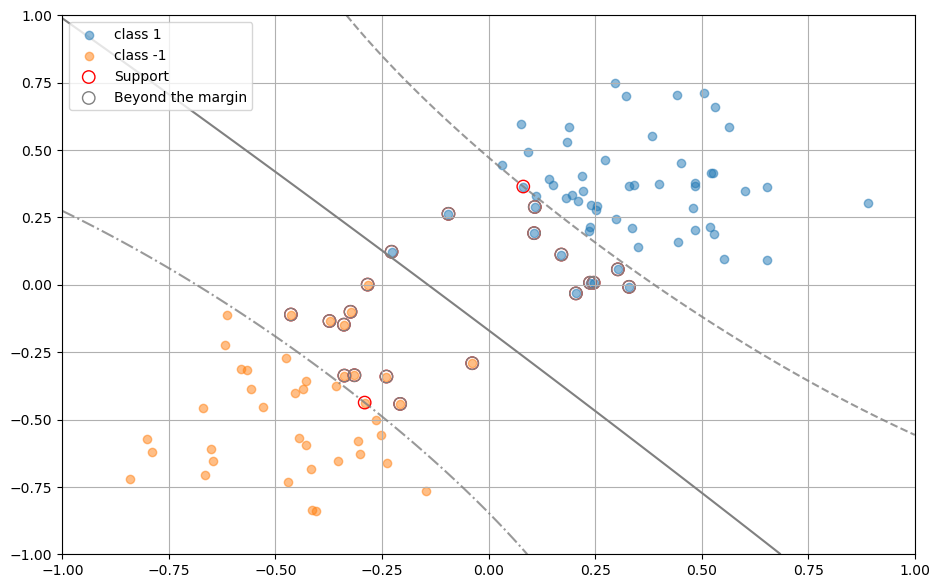

In [11]:
sigma = 1.5
C=1.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-13)
train_dataset = datasets['dataset_1']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

#### Comparaison avec scikit

In [12]:
clf = SVC(C=C, kernel='rbf', gamma=1/(2*sigma**2))
clf.fit(train_dataset['x'], train_dataset['y'])

print_comparaison()



Résultats algorithme maison :-)
Number of support vectors = 22
Support vectors (jusqu'à 10) = [[-0.4638     -0.11043985]
 [ 0.2464275   0.00756614]
 [-0.20749121 -0.44200841]
 [-0.23974348 -0.34053975]
 [-0.29073324 -0.43713225]
 [ 0.10667482  0.19157822]
 [-0.28374729  0.00067824]
 [ 0.17074108  0.11208645]
 [-0.37324636 -0.13451019]
 [-0.09415206  0.26330923]]
Alphas (jusqu'à 10) = [-1.          1.         -1.         -1.         -0.80189834  1.
 -1.          1.         -1.          1.        ]
b = 0.026086484551332303


Résultats algo scikit :
Number of support vectors = 22
Support vectors (jusqu'à 10)= [[-0.4638     -0.11043985]
 [-0.20749121 -0.44200841]
 [-0.23974348 -0.34053975]
 [-0.29073324 -0.43713225]
 [-0.28374729  0.00067824]
 [-0.37324636 -0.13451019]
 [-0.32392349 -0.10024398]
 [-0.33838408 -0.33703306]
 [-0.31481833 -0.33564543]
 [-0.33944758 -0.14801147]]
Dual coefficients (jusqu'à 10)= [[-1.         -1.         -1.         -0.80140629 -1.         -1.
  -1.         -

### Dataset 2
#### Linear SVM

Number of support vectors = 62


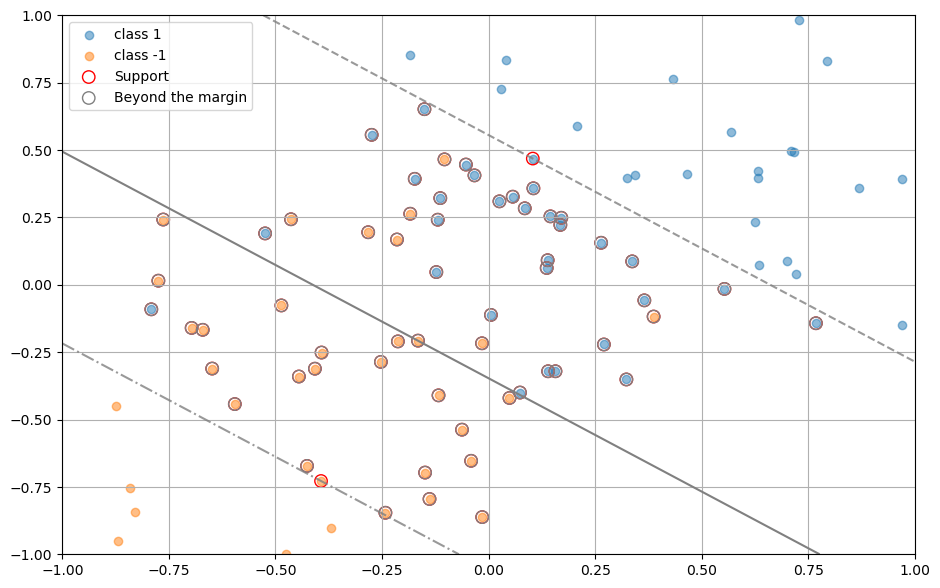

In [13]:
C=.1
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

In [14]:
clf = SVC(C=C, kernel='linear')
clf.fit(train_dataset['x'], train_dataset['y'])

print_comparaison()



Résultats algorithme maison :-)
Number of support vectors = 62
Support vectors (jusqu'à 10) = [[-0.46360001  0.24312029]
 [ 0.2640437   0.15581962]
 [-0.39190443 -0.25147652]
 [-0.40747375 -0.31138957]
 [-0.15054692  0.65157217]
 [-0.44501448 -0.34040582]
 [ 0.156855   -0.32086771]
 [ 0.76794595 -0.14270384]
 [ 0.04901759 -0.42001683]
 [-0.01548697 -0.21707951]]
Alphas (jusqu'à 10) = [-0.1  0.1 -0.1 -0.1  0.1 -0.1  0.1  0.1 -0.1 -0.1]
b = 0.2149258622124424


Résultats algo scikit :
Number of support vectors = 62
Support vectors (jusqu'à 10)= [[-0.46360001  0.24312029]
 [-0.39190443 -0.25147652]
 [-0.40747375 -0.31138957]
 [-0.44501448 -0.34040582]
 [ 0.04901759 -0.42001683]
 [-0.01548697 -0.21707951]
 [-0.11746648 -0.4102645 ]
 [-0.10349458  0.46535648]
 [-0.28249272  0.19497963]
 [-0.76333438  0.24207902]]
Dual coefficients (jusqu'à 10)= [[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1 -0.1]]
b = [0.31169898]


Valeur des alpha_i * y_i du modèle maison (à comparer à C=0.1), aux indic

#### Gaussian SVM

Number of support vectors = 4


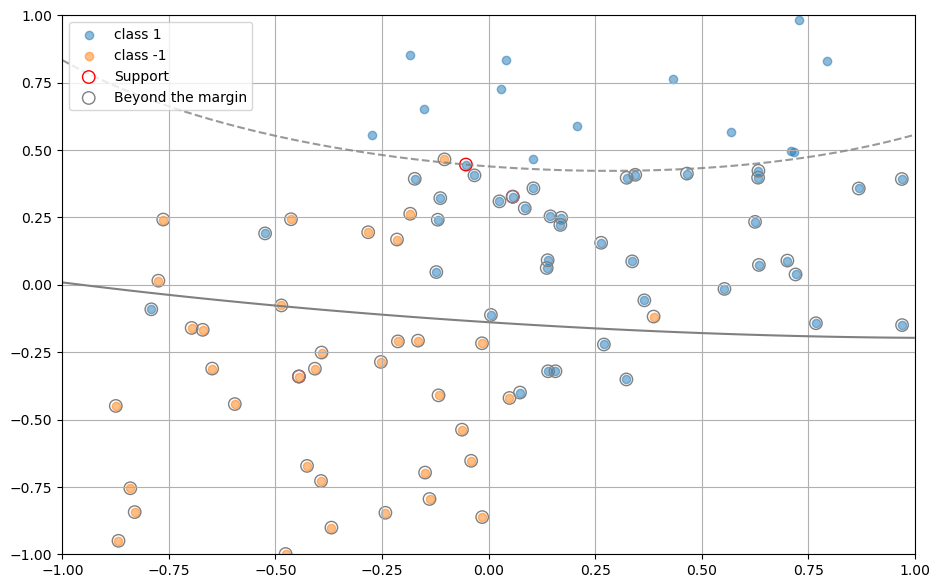

In [15]:
sigma = 1.5
C=1.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_2']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

In [16]:
clf = SVC(C=C, kernel='rbf', gamma=1/(2*sigma**2))
clf.fit(train_dataset['x'], train_dataset['y'])

print_comparaison()



Résultats algorithme maison :-)
Number of support vectors = 4
Support vectors (jusqu'à 10) = [[-0.44501448 -0.34040582]
 [ 0.0566331   0.32682143]
 [ 0.16966221 -1.06572757]
 [-0.05323522  0.4460712 ]]
Alphas (jusqu'à 10) = [-5.13466612e-01  1.06897188e-13 -4.76634132e-01  9.90100744e-01]
b = -0.01937524700493931


Résultats algo scikit :
Number of support vectors = 41
Support vectors (jusqu'à 10)= [[-0.46360001  0.24312029]
 [-0.39190443 -0.25147652]
 [-0.40747375 -0.31138957]
 [-0.44501448 -0.34040582]
 [ 0.04901759 -0.42001683]
 [-0.01548697 -0.21707951]
 [-0.11746648 -0.4102645 ]
 [-0.10349458  0.46535648]
 [-0.28249272  0.19497963]
 [-0.76333438  0.24207902]]
Dual coefficients (jusqu'à 10)= [[-1.         -1.         -1.         -0.51079732 -1.         -1.
  -1.         -1.         -1.         -1.        ]]
b = [-0.01843051]


Valeur des alpha_i * y_i du modèle maison (à comparer à C=1.0), aux indices de vecteurs support indiqués par scikit :
alpha_i * y_i (jusqu'à 10) = [1.     

### Dataset 3
#### Linear SVM

Number of support vectors = 197


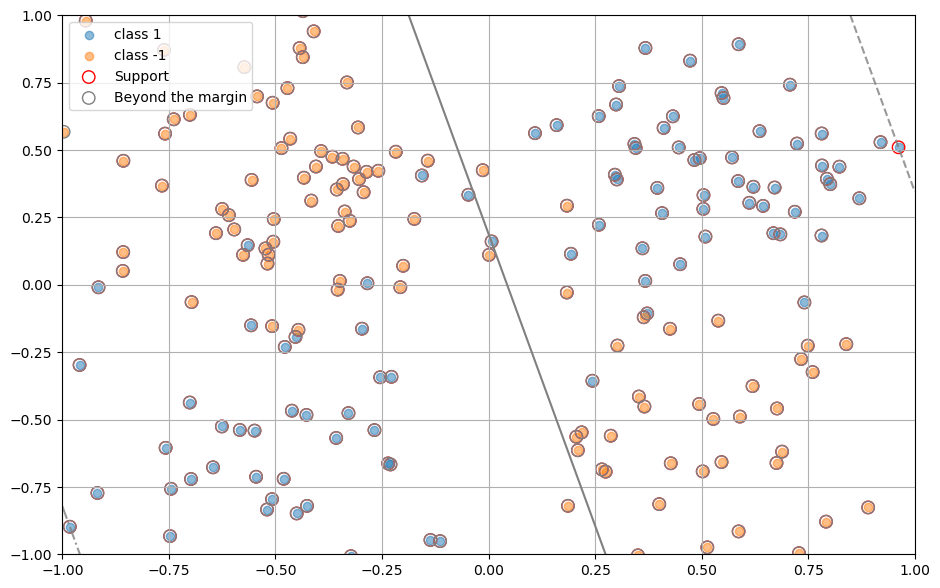

In [17]:
C=1.
kernel = Linear().kernel
model = KernelSVC(C=C, kernel=kernel, epsilon=1e-14)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

In [18]:
clf = SVC(C=C, kernel='linear')
clf.fit(train_dataset['x'], train_dataset['y'])

print_comparaison()



Résultats algorithme maison :-)
Number of support vectors = 197
Support vectors (jusqu'à 10) = [[ 0.96183198  0.51002321]
 [ 0.53879923 -0.13323107]
 [-0.41597808  0.31220601]
 [ 0.4939895  -0.44235408]
 [ 0.50372032  0.28159124]
 [ 0.18620868 -0.82025984]
 [-0.70565464 -1.02649752]
 [ 0.52718328 -0.4979349 ]
 [-0.34898515  0.01427642]
 [ 0.76026673 -0.32383734]]
Alphas (jusqu'à 10) = [ 4.19197954e-13 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  1.00000000e+00 -1.00000000e+00  1.00000000e+00 -1.00000000e+00
 -1.00000000e+00 -1.00000000e+00]
b = -0.029570682559192745


Résultats algo scikit :
Number of support vectors = 184
Support vectors (jusqu'à 10)= [[ 0.53879923 -0.13323107]
 [-0.41597808  0.31220601]
 [ 0.4939895  -0.44235408]
 [ 0.18620868 -0.82025984]
 [ 0.52718328 -0.4979349 ]
 [-0.34898515  0.01427642]
 [ 0.76026673 -0.32383734]
 [ 0.21841323 -0.54769177]
 [-0.29311605  0.34338807]
 [-0.1742943   0.24429152]]
Dual coefficients (jusqu'à 10)= [[-1. -1. -1. -1. -1. -1. -1.

#### Gaussian SVM

Number of support vectors = 43


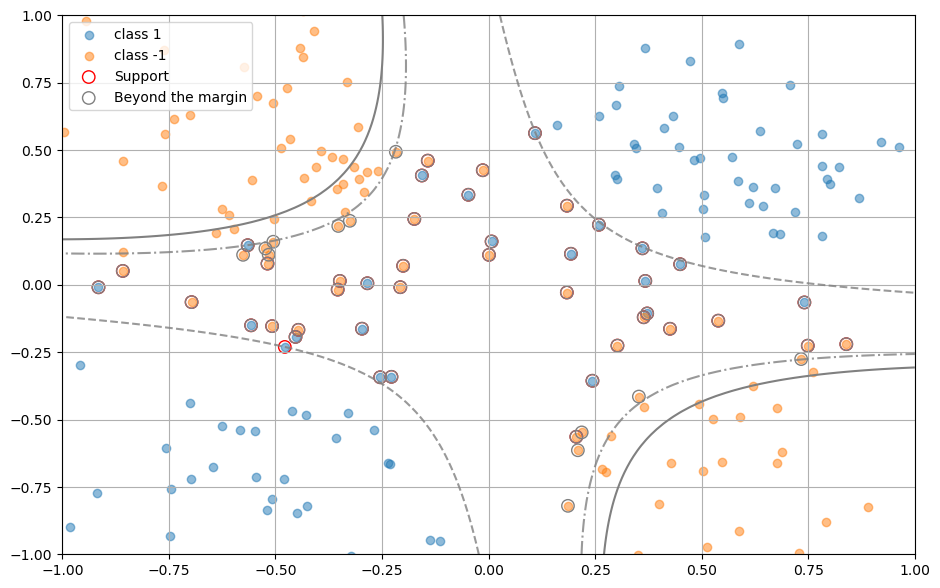

In [19]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')

In [20]:
clf = SVC(C=C, kernel='rbf', gamma=1/(2*sigma**2))
clf.fit(train_dataset['x'], train_dataset['y'])

print_comparaison()



Résultats algorithme maison :-)
Number of support vectors = 43
Support vectors (jusqu'à 10) = [[ 0.53879923 -0.13323107]
 [-0.34898515  0.01427642]
 [ 0.25872858  0.22264745]
 [-0.1742943   0.24429152]
 [-0.28438361  0.00566654]
 [-0.25437713 -0.34313531]
 [ 0.10885351  0.56256461]
 [ 0.42560718 -0.16331899]
 [-0.04738958  0.33395528]
 [-0.69678349 -0.06432663]]
Alphas (jusqu'à 10) = [-100.         -100.           92.65307101 -100.          100.
  100.           61.52952561 -100.          100.         -100.        ]
b = 1.9458470919584374


Résultats algo scikit :
Number of support vectors = 42
Support vectors (jusqu'à 10)= [[ 0.53879923 -0.13323107]
 [-0.34898515  0.01427642]
 [-0.1742943   0.24429152]
 [ 0.42560718 -0.16331899]
 [-0.69678349 -0.06432663]
 [ 0.36395359 -0.12048624]
 [-0.14265788  0.46053655]
 [-0.35400897 -0.01801291]
 [ 0.20576571 -0.56390764]
 [-0.51869939  0.07858045]]
Dual coefficients (jusqu'à 10)= [[-100.         -100.         -100.         -100.         -100.

## Conclusion des essais comparatifs : 

- le code "maison" donne des résultats comparables à ceux de Scikit sur les trois datasets et les deux kernels.
- toutefois, il y a parfois des écarts, dans le nombre des support vectors
- ces écarts correspondent en très grande majorité à des cas $\alpha_i y_i = C$. Il est vraisemblable que ce sont des problèmes d'arrondis numériques.